<a href="https://colab.research.google.com/github/POLSEAN/Influence-Analysis/blob/main/labs/day_7/ESS24_07_01_double_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Post-Double selection**

In [1]:
# Install packages
list.of.packages <- c("ivreg", "tidyverse", "dplyr","estimatr","base","hdm","naivereg")
new.packages <- list.of.packages[!(list.of.packages %in% installed.packages()[,"Package"])]
if(length(new.packages)) install.packages(new.packages, repos = "http://cran.us.r-project.org")

# Load the packages
library(ivreg)
library(tidyverse)
library(estimatr)
library(base)
library(hdm)
library(naivereg)

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘cowplot’, ‘Deriv’, ‘microbenchmark’, ‘numDeriv’, ‘doBy’, ‘SparseM’, ‘MatrixModels’, ‘minqa’, ‘nloptr’, ‘iterators’, ‘carData’, ‘abind’, ‘pbkrtest’, ‘quantreg’, ‘lme4’, ‘zoo’, ‘foreach’, ‘shape’, ‘car’, ‘Formula’, ‘lmtest’, ‘RcppEigen’, ‘glmnet’, ‘checkmate’


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


## **The Data**

We use data from the U.S. National Longitudinal Survey of Young Men (NLSYM) in 1976, where some variables dating back to earlier years. This dataset is provided in the `ivreg` package as `SchoolingReturns`.

This data set was originally used by David Card to study the effect of schooling on earnings in a classical models for wage determination. It was subsequently employed to illustrate 2SLS estimation in introductory econometrics textbooks.


*Variables*
```
wage: Raw wages in 1976 (in cents per hour).
education: Education in 1976 (in years).
experience: Years of labor market experience, computed as age - education - 6.
ethnicity: Factor indicating ethnicity. Is the individual African-American ("afam") or not ("other")?
smsa: Factor. Does the individual reside in a SMSA (standard metropolitan statistical area) in 1976?
south: Factor. Does the individual reside in the South in 1976?
age: Age in 1976 (in years).
nearcollege: Factor. Did the individual grow up near a 4-year college?
nearcollege2: Factor. Did the individual grow up near a 2-year college?
nearcollege4: Factor. Did the individual grow up near a 4-year public or private college?
enrolled: Factor. Is the individual enrolled in college in 1976?
married: factor. Is the individual married in 1976?
education66: Education in 1966 (in years).
smsa66: Factor. Does the individual reside in a SMSA in 1966?
south66: Factor. Does the individual reside in the South in 1966?
feducation: Father's educational attainment (in years). Imputed with average if missing.
meducation: Mother's educational attainment (in years). Imputed with average if missing.
fameducation: Ordered factor coding family education class (from 1 to 9).
kww: Knowledge world of work (KWW) score.
iq: Normed intelligence quotient (IQ) score
parents14: Factor coding living with parents at age 14: both parents, single mother, step parent, other
library14: Factor. Was there a library card in home at age 14?

```

In [12]:
# Load the data available in `ivreg' package
data("SchoolingReturns", package = "ivreg")
#summary(SchoolingReturns)
colnames(SchoolingReturns)

[1] "wage"         "education"    "experience"   "ethnicity"    "smsa"        
 [6] "south"        "age"          "nearcollege"  "nearcollege2" "nearcollege4"
[11] "enrolled"     "married"      "education66"  "smsa66"       "south66"     
[16] "feducation"   "meducation"   "fameducation" "kww"          "iq"          
[21] "parents14"    "library14"

### **Data description**


  no  yes 
 957 2053 

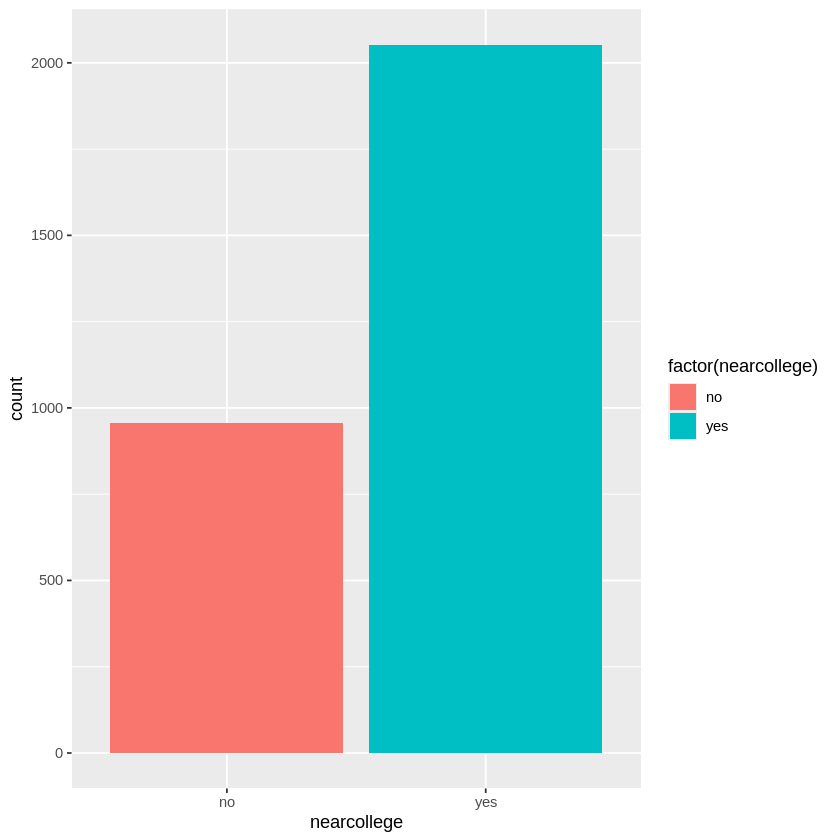

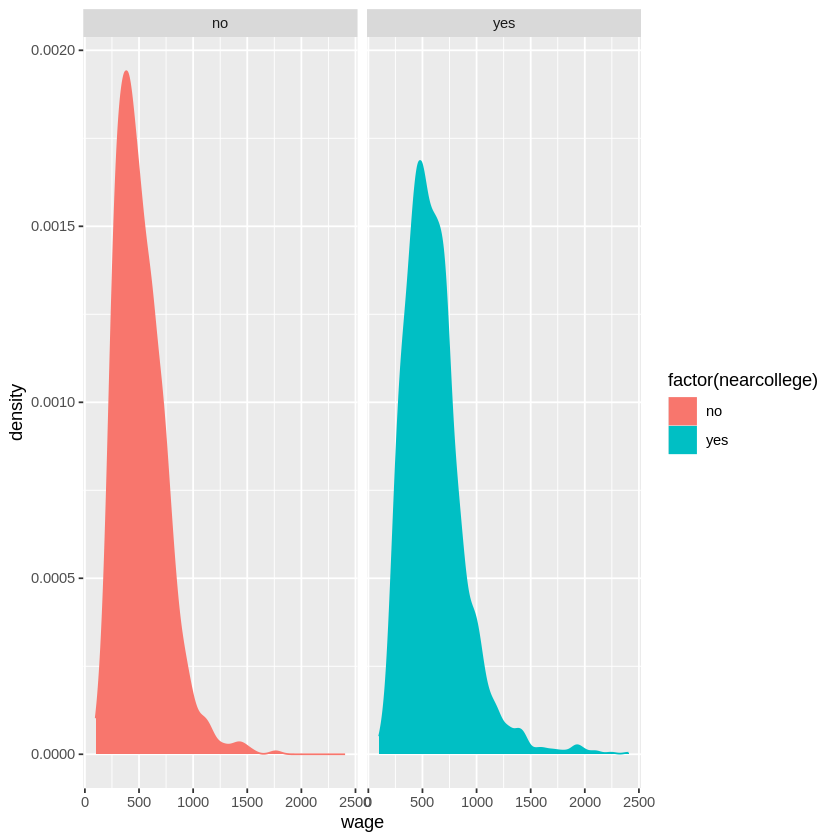

In [ ]:
# Tabulate nearcollege
table(SchoolingReturns$nearcollege)

# Distance from school
hist = ggplot(SchoolingReturns, aes(x = nearcollege, fill = factor(nearcollege))) + geom_bar()
hist

# Densities by proximity to colleage
dens = ggplot(SchoolingReturns, aes(x = wage, color = factor(nearcollege), fill = factor(nearcollege)) )  +
                    geom_density() + facet_wrap(.~nearcollege)
dens


###**The Code**

In [ ]:
## Naive OLS with all variables
ols = lm_robust(log(wage) ~ education + (poly(experience, 2) + ethnicity + smsa + south)^3, data = SchoolingReturns)
coef.ols = summary(ols)$coefficients[2]
coef.ols

[1] 0.07311749

###**Hand-coded Double Selection**

In [11]:
# Outcome
Y = log(SchoolingReturns$wage)
# Treatment
D = SchoolingReturns$education
# Create main effects matrix
X = model.matrix(~ 0 + (poly(experience, 2) + ethnicity + smsa + south)^3, data = SchoolingReturns)

In [ ]:
# Set seed for replicability
set.seed(1408)

# Step 1: Select variables in outcome regression
sel_y = rlasso(X,Y, post = FALSE)
which(sel_y$beta != 0)
# Step 2: Select variables in treatment regression
sel_d = rlasso(X,D, post = FALSE)
which(sel_d$beta != 0)

# Step 3: OLS regresssion of Y on D and the union of the selected variables in Steps 1&2
X_sel_union_ = X[,sel_y$beta != 0 | sel_d$beta != 0]
ds_hand = lm_robust(Y ~ D + X_sel_union_)
summary(ds_hand)

#ds_hand$coefficients[2]
#ds_hand$std.error[2]

poly(experience, 2)1 
                                          1 
                       poly(experience, 2)2 
                                          2 
                             ethnicityother 
                                          3 
                              ethnicityafam 
                                          4 
                                    smsayes 
                                          5 
                                   southyes 
                                          6 
               poly(experience, 2)1:smsayes 
                                          9 
               poly(experience, 2)2:smsayes 
                                         10 
                     ethnicityafam:southyes 
                                         14 
poly(experience, 2)1:ethnicityafam:southyes 
                                         18

poly(experience, 2)1 
                                          1 
                             ethnicityother 
                                          3 
                                    smsayes 
                                          5 
                                   southyes 
                                          6 
              poly(experience, 2)1:southyes 
                                         11 
 poly(experience, 2)2:ethnicityafam:smsayes 
                                         17 
poly(experience, 2)1:ethnicityafam:southyes 
                                         18

1 coefficient  not defined because the design matrix is rank deficient





Call:
lm_robust(formula = Y ~ D + X_sel_union_)

Standard error type:  HC2 

Coefficients: (1 not defined because the design matrix is rank deficient)
                                                        Estimate Std. Error
(Intercept)                                              5.27853   0.051288
D                                                        0.07276   0.003666
X_sel_union_poly(experience, 2)1                         9.76745   0.823789
X_sel_union_poly(experience, 2)2                        -1.24171   0.551326
X_sel_union_ethnicityother                                    NA         NA
X_sel_union_ethnicityafam                               -0.11692   0.028356
X_sel_union_smsayes                                      0.15101   0.015253
X_sel_union_southyes                                    -0.10123   0.017193
X_sel_union_poly(experience, 2)1:smsayes                 0.15236   0.783627
X_sel_union_poly(experience, 2)2:smsayes                -1.67568   0.807933
X_sel_union_

###**Double-selection with `hdm` package**

In [78]:
# Set seed for replicability
set.seed(1408)

# Estimate the effect using `rlassoEffect' command
ds1= rlassoEffect(X,Y,D, method = "double selection",post = FALSE)
summary(ds1)

# Print selection matrix
print_coef(ds1, selection.matrix = TRUE)

# Compare point estimate as the hand-coded version:
#answer = all.equal(as.numeric(ds1$coefficients),as.numeric(ds_hand$coefficients[2]))
#print(paste0("Are the coefficients identical? ", answer))

[1] "Estimates and significance testing of the effect of target variables"
   Estimate. Std. Error t value Pr(>|t|)    
d1  0.072759   0.003665   19.85   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1




[1] "Estimated target coefficients"
        d1 
0.07275877 

[1] "Matrix with selection index from auxiliary regressions"

                                            [,1]
poly(experience, 2)1                        "x" 
poly(experience, 2)2                        "x" 
ethnicityother                              "x" 
ethnicityafam                               "x" 
smsayes                                     "x" 
southyes                                    "x" 
poly(experience, 2)1:ethnicityafam          "." 
poly(experience, 2)2:ethnicityafam          "." 
poly(experience, 2)1:smsayes                "x" 
poly(experience, 2)2:smsayes                "x" 
poly(experience, 2)1:southyes               "x" 
poly(experience, 2)2:southyes               "." 
ethnicityafam:smsayes                       "." 
ethnicityafam:southyes                      "x" 
smsayes:southyes                            "." 
poly(experience, 2)1:ethnicityafam:smsayes  "." 
poly(experience, 2)2:ethnicityafam:smsayes 

In [15]:
## Double selection for partialling-out
# Set seed for replicability
set.seed(1408)

ds2_po = rlassoEffect(X,Y,D, method = "partialling out",post=FALSE) #default
summary(ds2_po)

[1] "Estimates and significance testing of the effect of target variables"
     Estimate. Std. Error t value Pr(>|t|)    
[1,]  0.072984   0.003505   20.82   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1



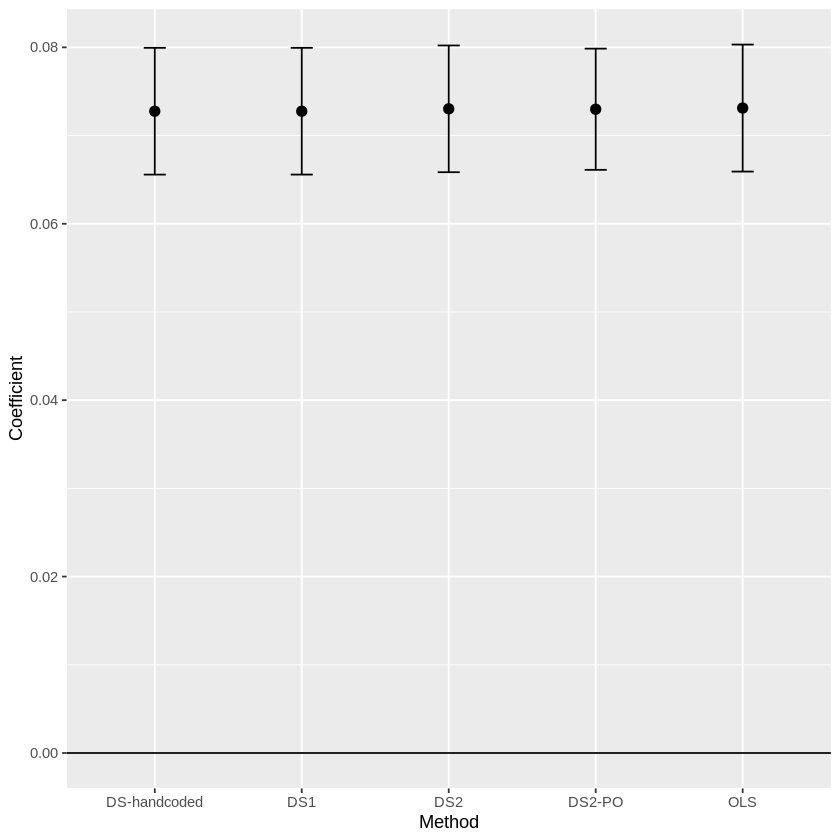

In [ ]:
# Graphical comparison of the results
Coefficient = c(ols$coefficients[2],ds_hand$coefficients[2],ds1$coefficients,ds2$coefficients,ds2_po$coefficients)
se =  c(ols$std.error[2],ds_hand$std.error[2],ds1$se,ds2$se,ds2_po$se)
data.frame(Coefficient,se,
                Method = c("OLS","DS-handcoded","DS1","DS2","DS2-PO"),
                cil = Coefficient - 1.96*se,
                ciu = Coefficient + 1.96*se)  %>%
  ggplot(aes(x=Method,y=Coefficient,ymin=cil,ymax=ciu)) + geom_point(size=2.5) + geom_errorbar(width=0.15)  +
  geom_hline(yintercept=0)

### **Post-Double Selection with IV**

1. In `hdm` package, the function `rlassoIV` conducts *triple selection* when a instrimental variable (IV) approach is needed.
2. In `naivereg` package, the function `DSIV` perform double-selection with IV using the procedure described in [2].



**References**

[1] V. Chernozhukov, C. Hansen, M. Spindler (2015). Post-selection and post-regularization inference in linear models with many controls and instruments. *American Economic Review: Paper & Proceedings*, 105(5), 486-490.

[2] Zhong, W., Gao, Y., Zhou, W., & Fan, Q. (2021). Endogenous treatment effect estimation using high-dimensional instruments and double selection. *Statistics & Probability Letters*, 169, 108967.

### **The Code**

In [35]:
# Instrumental variables (IVs)
z  <- ifelse(SchoolingReturns$nearcollege == "yes", 1, 0)   # convert to numeric binary variable
z2 <- ifelse(SchoolingReturns$nearcollege2 == "yes", 1, 0)  # convert to numeric binary variable
z4 <- ifelse(SchoolingReturns$nearcollege4 == "yes", 1, 0)  # convert to numeric binary variable

Z = model.matrix(~ (z + z2 + z4 + meducation + feducation+ poly(age, 2))^3, data = SchoolingReturns)

In [39]:
iv <- ivreg(log(wage) ~ education + (poly(experience, 2) + ethnicity + smsa + south)^3 |
                nearcollege + (poly(age, 2) + ethnicity + smsa + south)^3,
              data = SchoolingReturns)
summary(iv)$coefficients[2,]

Estimate Std. Error    t value   Pr(>|t|) 
0.13505164 0.05465853 2.47082461 0.01353562

In [80]:
# Post-Double selection with one IV: hand-coded (for partialling-out)
rY = rlasso(X,Y)$res
rD = rlasso(X,D)$res
rZ = rlasso(X,z)$res
ivfit.lasso = tsls(rY ~ rD | rZ, intercept= FALSE)
print(cbind(ivfit.lasso$coef, ivfit.lasso$se), digits=4)

     [,1]    [,2]
rD 0.1326 0.04988


In [25]:
# Post-Double selection with one IV: `hdm` package
ds.iv.xsel = rlassoIV(X, D, Y, z, select.X=TRUE, select.Z=FALSE)
summary(ds.iv.xsel)

# Equivalent to:
#ds.iv.xsel = rlassoIVselectX(X, D, Y, z)
#summary(ds.iv.xsel)
#coef(ds.iv.xsel, selection.matrix = T) # print selection matrix

[1] "Estimation and significance testing of the effect of target variables in the IV regression model"
    coeff.     se. t-value p-value   
d1 0.13260 0.04988   2.658 0.00786 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1




In [30]:
# Post-Double selection with multiple IVs: `hdm` package
ds.iv.xzsel = rlassoIV(X, D, Y, Z, select.X=TRUE, select.Z=TRUE)
summary(ds.iv.xzsel)
coef(ds.iv.xzsel, selection.matrix = T) # print selection matrix



Estimates and Significance Testing of the effect of target variables in the IV regression model 
     coeff.      se. t-value p-value    
d1 0.072583 0.003639   19.95  <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1




,y,d1,global
"poly(experience, 2)1",.,x,x
"poly(experience, 2)2",x,.,x
ethnicityother,x,x,x
ethnicityafam,x,.,x
smsayes,x,x,x
southyes,x,x,x
"poly(experience, 2)1:ethnicityafam",.,.,.
"poly(experience, 2)2:ethnicityafam",.,.,.
"poly(experience, 2)1:smsayes",x,.,x
"poly(experience, 2)2:smsayes",x,.,x


[1] 0.1350516

[1] 0.05465853

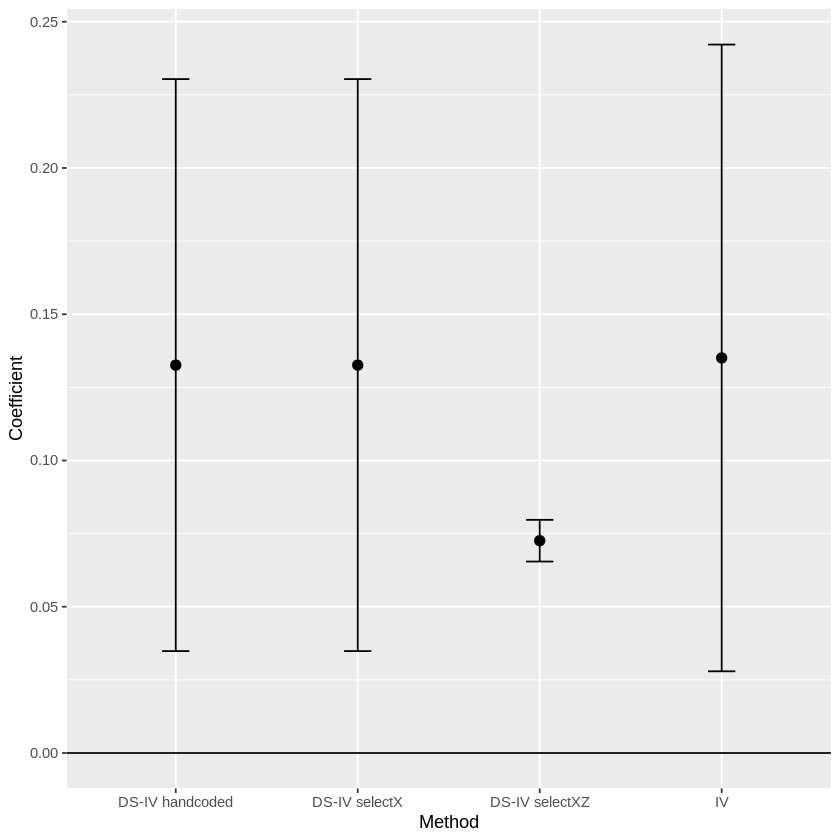

In [41]:
# Graphical comparison of the results
Coefficient = c(summary(iv)$coefficients[2,1],ivfit.lasso$coefficients,ds.iv.xsel$coefficients,ds.iv.xzsel$coefficients)
se =  c(summary(iv)$coefficients[2,2],ivfit.lasso$se,ds.iv.xsel$se,ds.iv.xzsel$se)
data.frame(Coefficient,se,
                Method = c("IV","DS-IV handcoded","DS-IV selectX","DS-IV selectXZ"),
                cil = Coefficient - 1.96*se,
                ciu = Coefficient + 1.96*se)  %>%
  ggplot(aes(x=Method,y=Coefficient,ymin=cil,ymax=ciu)) + geom_point(size=2.5) + geom_errorbar(width=0.15)  +
  geom_hline(yintercept=0)

In [76]:
# Display table that compares results
library(xtable)

table= matrix(0, 4, 2)
table[1,]= cbind(ds1$coefficients,ds1$se)
table[2,]= cbind(summary(iv)$coefficients[2,1],summary(iv)$coefficients[2,2])
table[3,]= cbind(ds.iv.xsel$coefficients, ds.iv.xsel$se)
table[4,]= cbind(ds.iv.xzsel$coefficients, ds.iv.xzsel$se)

colnames(table)= c("Estimate", "Std. Error")
rownames(table)= c("DS OLS regression", "IV estimation ", "IV selection on X", "IV selection on X and Z")
tab= xtable(table)
tab

,Estimate,Std. Error
,<dbl>,<dbl>
DS OLS regression,0.07275877,0.003665224
IV estimation,0.13505164,0.054658532
IV selection on X,0.13260483,0.049884660
IV selection on X and Z,0.07258280,0.003638521


With too many *weak instruments* (IV.XZsel), the 2SLS estimator is biased toward the OLS estimator.  

### **Double-selection with `naivereg` package**

* Step 1: Regress Y on X using using Lasso, estimate the coefficients beta and select control variables (c1).

* Step2: Regress D on instruments Z and controls X, estimate the
optimal instrument and obtain the set of selected controls (cx).

* Step 3: 2SLS regression of Y on the estimated optimal instrument and the union (c3) of c1 and cx.

Unfortunately, the algorithm does not calculate the standard errors in the last stage, and it is not built with `cv_glmnet`.  

In [60]:
# DS with only one IV -- i.e., nearcollege
res = DSIV(Y,X,z,D,family='gaussian', criterion='BIC')
res$c1 #Variable indication of the selected in the first step (control variables x).
res$cx #Variable indication of selected control variables in the second step.
res$cz #Variable indication of selected instrumental variables in the second step.
res$c3 #Union of c1 and cx on control variables

res$betaD

[1]  1  2  3  4  5  6  8  9 10 11 14 18

[1]  0  0  0  0  0  0 17

[1] 23

[1]  1  2  3  4  5  6  8  9 10 11 14 18 17

0.1337203


In [61]:
# DS with only multiple IVs
res = DSIV(Y,X,Z,D,family='gaussian', criterion='BIC')
res$c1 #Variable indication of the selected in the first step (control variables x).
res$cx #Variable indication of selected control variables in the second step.
res$cz #Variable indication of selected instrumental variables in the second step.
res$c3 #Union of c1 and cx on control variables

res$betaD

[1]  1  2  3  4  5  6  8  9 10 11 14 18

[1] 0

[1] 29 46 47

[1]  1  2  3  4  5  6  8  9 10 11 14 18

0.08692095
